Proyecto 1.

A/B test de proporciones. El experimento estadistico.

Como realizar un A/B test correctamente.

In [1]:
#importamos los paquetes necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

**Etapa N1.**

Tarea: verificar los resultados de Evan Miller. 

segun Evan Miller:

baseline conversion rate: 20%

Minimum Detectable Effect: 5%

sample size = 1030

In [2]:
mde = 0.05  #efecto minimo detectado.
baseline = 0.2 #rata de conversion de baseline
sample_size = 1030

#generamos las muestras.
a = np.random.binomial(1, baseline, size=sample_size).mean()

a # valor cercano a baseline.

0.20776699029126214

In [3]:
#Realicemos un A/B test.

a = np.random.binomial(1, baseline, size=sample_size).mean() #control
b = np.random.binomial(1, baseline + mde, size=sample_size).mean() #test


El 1er objetivo es realizar varios test estadisticos sobre nuestras muestras.

H0: No hay diferencia entre los grupos == las muestras provienen de una misma distribucion.

In [4]:
#importamos la funcion para hacer simulaciones de Monte-Carlo
#from tqdm.notebook import tqdm
from statsmodels.stats.proportion import proportions_ztest


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
a = np.random.binomial(1, baseline, size=sample_size)
b = np.random.binomial(1, baseline + mde, size=sample_size)

In [6]:
proportions_ztest([a.sum(), b.sum()], [len(a), len(b)]) #cantidad de exitos en c/u grupo y numero de observaciones.
#test con dos colas +/- 0.05

(-3.5641122501755484, 0.0003650897047634572)

In [7]:
#Realizamos nuestro MC
from tqdm.notebook import tqdm

In [8]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
result[:10]  # lista con los primeros 10 p_values

[0.004744908165012663,
 0.1578530543770149,
 0.00043265988839328684,
 4.967971607770258e-05,
 0.00043149565413132246,
 0.0024787855623294055,
 0.37527108021873234,
 0.008163354419626479,
 0.050824850751094795,
 0.0008074853578106412]

In [10]:
t = pd.Series(result)

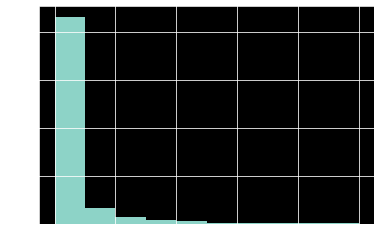

In [11]:
t.hist();

In [12]:
  t < 0.05 # nuestro resultado para el nivel de significancia.

0        True
1       False
2        True
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Length: 10000, dtype: bool

In [13]:
(t < 0.05).mean()  # la potencia estadistica (1-beta) valor cercano a 0.80.
#modelamos con MC la potencia y el efecto con ayuda de un test estadistico.
#Reproducimos los resultados de Evan Miller 

0.7765

In [14]:
#Realizamos un t-test con dos colas.
from scipy.stats import ttest_ind


In [16]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = ttest_ind(a, b, equal_var=False)
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
t = pd.Series(result)

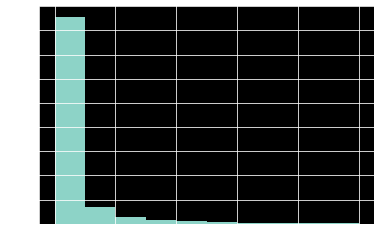

In [18]:
t.hist();

In [19]:
t < 0.05  # nuestro resultado para el nivel de significancia.

0        True
1        True
2        True
3        True
4        True
        ...  
9995    False
9996    False
9997    False
9998     True
9999     True
Length: 10000, dtype: bool

In [20]:
(t < 0.05).mean() 

0.778

In [21]:
sample_size = 800 #Reducimos el tamaño de la muestra

from scipy.stats.mstats_basic import mannwhitneyu
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = mannwhitneyu(a, b)
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
t = pd.Series(result)

In [23]:
(t < 0.05).mean() # el tamaño de la muestra con MannWhitney se diferencia de valor de Evan Miller. 

0.6664

In [24]:
sample_size = 1030 #Reducimos el tamaño de la muestra

from scipy.stats.mstats_basic import mannwhitneyu
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline, size=sample_size)
  _, p_val = mannwhitneyu(a, b)
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
t = pd.Series(result)

In [26]:
(t < 0.05).mean()  # el poder estadistico resulto ser dos veces menor.
#la significacion esta relacionada con la rata de falsos positivos.Probabilidad de cometer error de
#tipo I. 

0.0508

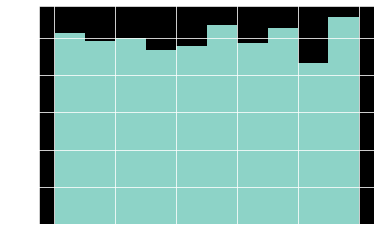

In [27]:
t.hist(); #distribuido uniformemente.

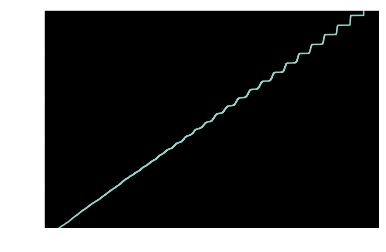

In [28]:
sns.ecdfplot(t);

In [29]:
t

0       0.910332
1       0.473691
2       0.483685
3       0.825700
4       0.337748
          ...   
9995    0.912502
9996    0.284938
9997    0.131614
9998    0.589122
9999    0.583252
Length: 10000, dtype: float64

**Etapa 2**

Seleccion optima de muestras antes de realizar el experimento.

In [31]:
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.20, 0.25)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80,
                                                     alpha=0.05, ratio=1))

In [32]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
t = pd.Series(result)

In [36]:
(t < 0.05).mean() #porcentaje observado == potencia estadistica.

0.8043

In [37]:
sample_size

1092

**Etapa 3**

Muestras con diferente proporcion 1/3 entre el grupo de control y el grupo de prueba.  

In [35]:
es = sms.proportion_effectsize(0.20, 0.25)
sample_size1 = round(sms.NormalIndPower().solve_power(es, power=0.80,
                                                     alpha=0.05, ratio=1/3))

In [38]:
sample_size1

2184

In [39]:
sample_size2 = round(sample_size1*1/3)
sample_size2

728

In [40]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size1)
  b = np.random.binomial(1, baseline + mde, size=sample_size2)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append(p_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
t = pd.Series(result)

In [43]:
(t < 0.05).mean() #porcentaje observado

0.8013

In [44]:
sample_size = 1000
baseline = 0.3
mde = 0.02
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append(p_val)

t = pd.Series(result)  
(t < 0.05).mean()  

  0%|          | 0/10000 [00:00<?, ?it/s]

0.1592

In [45]:
sample_size = 9000
baseline = 0.3
mde = 0.02
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append(p_val)

t = pd.Series(result)  
(t < 0.05).mean()  

  0%|          | 0/10000 [00:00<?, ?it/s]

0.8284

In [46]:
#Hallamos el tamaño de la muestra para obtener el poder deseado.
es = sms.proportion_effectsize(0.30, 0.32)
round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

8392

**Etapa 4**

Analogo de Machine Learnig con A/B test.

In [47]:
sample_size = 1000
baseline = 0.2
mde = 0.05
result = []
for _ in tqdm(range(1000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline + mde, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append([1, p_val])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
#este es un clasificador que nos da la probabilidad de que un 1 es un 1.
t = pd.DataFrame(result, columns=['y_true', 'y_score'])  #y_score=p-value
t

y_true   y_score
0         1  0.161161
1         1  0.002711
2         1  0.913888
3         1  0.002545
4         1  0.036965
..      ...       ...
995       1  0.000045
996       1  0.001208
997       1  0.000711
998       1  0.000528
999       1  0.285697

[1000 rows x 2 columns]

In [49]:
t['y_pred'] = (t['y_score'] < 0.05)*1 #transformacion a codigo binario

In [50]:
#Vemos algunos false positive results.
t

y_true   y_score  y_pred
0         1  0.161161       0
1         1  0.002711       1
2         1  0.913888       0
3         1  0.002545       1
4         1  0.036965       1
..      ...       ...     ...
995       1  0.000045       1
996       1  0.001208       1
997       1  0.000711       1
998       1  0.000528       1
999       1  0.285697       0

[1000 rows x 3 columns]

In [51]:
t['y_pred'].mean() #porcentaje de acierto

0.776

In [52]:
sample_size = 1000
baseline = 0.2
mde = 0.05
result = []
for _ in tqdm(range(1000)):
  a = np.random.binomial(1, baseline, size=sample_size)
  b = np.random.binomial(1, baseline, size=sample_size)
  _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  result.append([0, p_val])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
t = pd.DataFrame(result, columns=['y_true', 'y_score'])  #y_score=p-value
t

y_true   y_score
0         0  0.911792
1         0  0.463571
2         0  0.869744
3         0  0.351933
4         0  0.659403
..      ...       ...
995       0  0.826780
996       0  0.866691
997       0  0.008410
998       0  0.541236
999       0  0.544861

[1000 rows x 2 columns]

In [54]:
t['y_pred'] = (t['y_score'] < 0.05)*1
t

y_true   y_score  y_pred
0         0  0.911792       0
1         0  0.463571       0
2         0  0.869744       0
3         0  0.351933       0
4         0  0.659403       0
..      ...       ...     ...
995       0  0.826780       0
996       0  0.866691       0
997       0  0.008410       1
998       0  0.541236       0
999       0  0.544861       0

[1000 rows x 3 columns]

In [55]:
t['y_pred'].mean()

0.044

In [56]:
sample_size = 1090
baseline = 0.2
mde = 0.05
class_balance = 0.5
result = []
for _ in tqdm(range(10000)):
  if np.random.binomial(1, class_balance):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append([0, p_val])  #generamos un experimento fracazado
  else:
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline+mde, size=sample_size)
    _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append([1, p_val])#generamos un experimento exitoso.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
t = pd.DataFrame(result, columns=['y_true', 'y_score'])  #y_score=p-value
t

y_true   y_score
0          1  0.004918
1          1  0.035171
2          0  0.789443
3          1  0.000732
4          1  0.004009
...      ...       ...
9995       0  0.957969
9996       1  0.000206
9997       0  0.631337
9998       1  0.014336
9999       1  0.000128

[10000 rows x 2 columns]

In [58]:
t['y_pred'] = (t['y_score'] < 0.05)*1
t

y_true   y_score  y_pred
0          1  0.004918       1
1          1  0.035171       1
2          0  0.789443       0
3          1  0.000732       1
4          1  0.004009       1
...      ...       ...     ...
9995       0  0.957969       0
9996       1  0.000206       1
9997       0  0.631337       0
9998       1  0.014336       1
9999       1  0.000128       1

[10000 rows x 3 columns]

In [59]:
t['y_pred'].mean()

0.4182

In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(t['y_true'], t['y_pred']))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      5000
           1       0.95      0.80      0.87      5000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [62]:
t['y_pred'] = (t['y_score'] < 0.1)*1

In [63]:
print(classification_report(t['y_true'], t['y_pred'])) #El error de tipo1 se encuentra en el recall de la clase 0.

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5000
           1       0.90      0.88      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [64]:
#En un 5% de los casos 0 se identifica como 1.
#recall 0 --> 1-alpha. Error de tipo I.
#recall 1 --> 1-beta. 1- error de tipo II. 
t['y_pred'] = (t['y_score'] < 0.05)*1

In [65]:
t[t['y_pred'] == 1]['y_true'].mean()  #esta es la precision. Y es la probabilidad de que el experimento en realidad
#fue exitoso.

0.9512195121951219

In [66]:
#cambiamos el balance de las clases.
sample_size = 1090
baseline = 0.2
mde = 0.05
class_balance = 0.95 #proporcion de 0.
result = []
for _ in tqdm(range(10000)):
  if np.random.binomial(1, class_balance):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append([0, p_val])  #generamos un experimento fracazado
  else:
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline+mde, size=sample_size)
    _, p_val = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append([1, p_val])#generamos un experimento exitoso.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [67]:
t = pd.DataFrame(result, columns=['y_true', 'y_score'])  #y_score=p-value
t

y_true   y_score
0          0  0.581491
1          0  0.088790
2          0  0.265269
3          0  0.875167
4          0  0.827415
...      ...       ...
9995       0  0.259596
9996       1  0.037229
9997       1  0.022899
9998       0  0.709922
9999       0  0.751647

[10000 rows x 2 columns]

In [68]:
t['y_pred'] = (t['y_score'] < 0.05)*1
t

y_true   y_score  y_pred
0          0  0.581491       0
1          0  0.088790       0
2          0  0.265269       0
3          0  0.875167       0
4          0  0.827415       0
...      ...       ...     ...
9995       0  0.259596       0
9996       1  0.037229       1
9997       1  0.022899       1
9998       0  0.709922       0
9999       0  0.751647       0

[10000 rows x 3 columns]

In [69]:
t['y_pred'].mean()

0.0846

In [70]:
print(classification_report(t['y_true'], t['y_pred']))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9505
           1       0.46      0.79      0.58       495

    accuracy                           0.94     10000
   macro avg       0.73      0.87      0.78     10000
weighted avg       0.96      0.94      0.95     10000



In [71]:
t[t['y_pred'] == 1]['y_true'].mean() #nuestra probabilidad de exito se redujo a 0.5. Solo un 5% de los 
#experimentos realizados son exitosos.

0.46335697399527187

In [72]:
t['y_pred'] = (t['y_score'] < 0.01)*1 #para aumentar la presicion disminuimos el p-value, pero cae el recall.
t

y_true   y_score  y_pred
0          0  0.581491       0
1          0  0.088790       0
2          0  0.265269       0
3          0  0.875167       0
4          0  0.827415       0
...      ...       ...     ...
9995       0  0.259596       0
9996       1  0.037229       0
9997       1  0.022899       0
9998       0  0.709922       0
9999       0  0.751647       0

[10000 rows x 3 columns]

In [73]:
print(classification_report(t['y_true'], t['y_pred']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9505
           1       0.78      0.61      0.68       495

    accuracy                           0.97     10000
   macro avg       0.88      0.80      0.83     10000
weighted avg       0.97      0.97      0.97     10000



el numero de experimentos exitosos siempre es mucho menor que el numeros de fracasos. El de experimentos exitosos que puedo dejar pasar aumenta pero dismunuye el numero de fracasos que puedo dejar pasar como exito.
Apriori la probabilidad de exito es pequeña.  

**!!!Final Proyecto1!!!**